# Implemenación en arquitectura **TPU**

In [24]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords

from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten
from keras.layers import GlobalMaxPooling1D
from keras.layers.embeddings import Embedding
from tensorflow.keras.layers import LSTM, SpatialDropout1D, Dropout
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer


In [25]:
%%time
import os
import gzip
import json
import string

import nltk # imports the natural language toolkit
import pandas as pd
import plotly

nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
CPU times: user 39.1 ms, sys: 5.82 ms, total: 45 ms
Wall time: 218 ms


In [26]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
instant_video = pd.read_json("/content/gdrive/MyDrive/Ejemplo NPL/NPL - Amazon/reviews_Amazon_Instant_Video_5.json.gz", lines=True, compression='gzip')
movies_tv = next(pd.read_json("/content/gdrive/MyDrive/Ejemplo NPL/NPL - Amazon/reviews_Movies_and_TV_5.json.gz", lines=True, compression='gzip', chunksize=100000))

In [27]:
movies_tv.head(3)
#print(instant_video.shape)
#print(movies_tv.shape)

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,target
0,ADZPIG9QOCDG5,0005019281,"Alice L. Larson ""alice-loves-books""","[0, 0]",This is a charming version of the classic Dick...,4,good version of a classic,1203984000,"02 26, 2008",1
1,A35947ZP82G7JH,0005019281,Amarah Strack,"[0, 0]",It was good but not as emotionally moving as t...,3,Good but not as moving,1388361600,"12 30, 2013",0
2,A3UORV8A9D5L2E,0005019281,Amazon Customer,"[0, 0]","Don't get me wrong, Winkler is a wonderful cha...",3,Winkler's Performance was ok at best!,1388361600,"12 30, 2013",0


In [28]:
movies_tv.groupby(['overall']).size().reset_index(name='count')

,overall,count
0,1,4726
1,2,4575
2,3,9166
3,4,21022
4,5,60511


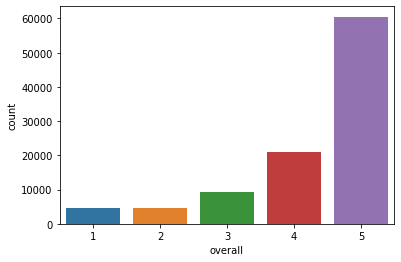

In [29]:
import seaborn as sns
sns.countplot(x='overall', data=movies_tv)

In [30]:
movies_tv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype   
---  ------          --------------   -----   
 0   reviewerID      100000 non-null  object  
 1   asin            100000 non-null  object  
 2   reviewerName    99020 non-null   object  
 3   helpful         100000 non-null  object  
 4   reviewText      100000 non-null  object  
 5   overall         100000 non-null  int64   
 6   summary         100000 non-null  object  
 7   unixReviewTime  100000 non-null  int64   
 8   reviewTime      100000 non-null  object  
 9   target          100000 non-null  category
dtypes: category(1), int64(2), object(7)
memory usage: 7.0+ MB


In [31]:
movies_tv['target'] = np.where(movies_tv.overall < 3.01, "0",
                                 np.where(movies_tv.overall > 3.01,"1","NA"))
movies_tv['target'] = pd.Categorical(movies_tv['target'])
movies_tv.dtypes 

reviewerID          object
asin                object
reviewerName        object
helpful             object
reviewText          object
overall              int64
summary             object
unixReviewTime       int64
reviewTime          object
target            category
dtype: object

In [32]:
movies_label = movies_tv.target.factorize(sort = True) # convierte a factores numéricos
movies_label

(array([1, 0, 0, ..., 1, 1, 1]),
 CategoricalIndex(['0', '1'], categories=['0', '1'], ordered=False, dtype='category'))

In [33]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

movies = movies_tv.reviewText.values # Esta es la matriz con las varibles de entrada
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(movies)
vocab_size = len(tokenizer.word_index) + 1
encoded_docs = tokenizer.texts_to_sequences(movies)
padded_sequence = pad_sequences(encoded_docs, maxlen=200)

In [34]:
print(tokenizer.word_index)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [35]:
print(movies[0])
print(encoded_docs[0])

This is a charming version of the classic Dicken's tale.  Henry Winkler makes a good showing as the "Scrooge" character.  Even though you know what will happen this version has enough of a change to make it better that average.  If you love A Christmas Carol in any version, then you will love this.
[8, 6, 3, 1335, 132, 4, 1, 138, 584, 1097, 149, 3, 44, 926, 13, 1, 4123, 114, 69, 150, 20, 123, 50, 59, 664, 8, 132, 35, 230, 4, 3, 668, 5, 107, 9, 121, 11, 1243, 42, 20, 84, 3, 545, 2745, 7, 112, 132, 98, 20, 59, 84, 8]


In [36]:


X_train, X_test, y_train, y_test = train_test_split(movies, movies_label[0], test_size=0.20, random_state=42)


In [37]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((80000,), (20000,), (80000,), (20000,))

In [38]:
pr = 128
a = (len(X_train)/pr)
ntrain = round(pr*(a-1))
print(ntrain)
b = (len(X_test)/pr)
ntest = round(pr*(b-1))
print(ntest)

79872
19872


In [39]:
X_train = X_train[0:ntrain]
X_test = X_test[0:ntest]
y_train = y_train[0:ntrain]
y_test = y_test[0:ntest]

#X_train = np.reshape(X_train,(79872,1))
#X_test = np.reshape(X_test,(19872,1))

In [40]:
X_train.tobytes

<function ndarray.tobytes>

In [41]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [42]:
# Adding 1 because of reserved 0 index
vocab_size = len(tokenizer.word_index) + 1

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [43]:
%tensorflow_version 2.x   # Para garantizar que la versión 2.x sea importada
import tensorflow as tf
print('Versión de TensorFlow: ' + tf.__version__)


`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `2.x   # Para garantizar que la versión 2.x sea importada`. This will be interpreted as: `2.x`.


TensorFlow is already loaded. Please restart the runtime to change versions.
Versión de TensorFlow: 2.4.1


In [44]:
# Se configura el código para detectar la TPU usando el módulo "distribute" y la función "ClusterResolver"

tf.random.set_seed(200)

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])  # Detectar TPU
  print('TPU encontrada ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: TPU no encontrada!')

# Luego de confirmar que se encuentra la TPU, se siguen los siguientes pasos:
# Primero, nos conectamos al cluster de Google Colab, utilizando la función "experimental_connect_to_cluster" 
tf.config.experimental_connect_to_cluster(tpu)
# En segundo lugar, inicializamos la TPU utilizando la función "experimental.initialize_tpu_system"  
tf.tpu.experimental.initialize_tpu_system(tpu)
# Finalmente se crea un objeto tipo "tpu_strategy" que permite la creación del modelo. 
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

TPU encontrada  ['10.118.213.210:8470']


INFO:tensorflow:Initializing the TPU system: grpc://10.118.213.210:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.118.213.210:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [45]:
from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open("/content/gdrive/MyDrive/Ejemplo NPL/glove.6B.100d.txt", encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [46]:
embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [54]:
with tpu_strategy.scope():
  embedding_vector_length = 128
  model = Sequential() 
  model.add(Embedding(vocab_size, embedding_vector_length, input_length=200) )
  model.add(SpatialDropout1D(0.25))
  model.add(LSTM(64, dropout=0.4, recurrent_dropout=0.5)) # LSTM define que estamos sobre un RN recurrente
  model.add(Dropout(0.4)) ## Dropout se utiliza para entrenar un porcentaje de las neuronas
  
  #model.add(Dense(64, activation='relu'))
  #model.add(Dropout(0.4))

  #model.add(Embedding(vocab_size, embedding_vector_length, input_length=200) )
  #model.add(SpatialDropout1D(0.25))
  #model.add(LSTM(90, dropout=0.4, recurrent_dropout=0.5))
  #model.add(Dropout(0.25)) ## Dropout se utiliza para entrenar un porcentaje de las neuronas
    
  model.add(Dense(1, activation='sigmoid')) 
  model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])  
  print(model.summary())

  

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 200, 128)          17564800  
_________________________________________________________________
spatial_dropout1d_4 (Spatial (None, 200, 128)          0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dropout_8 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 65        
Total params: 17,614,273
Trainable params: 17,614,273
Non-trainable params: 0
_________________________________________________________________
None


Entrenamiento del modelo

In [55]:
import timeit
X_train = X_train.astype(np.float32)
y_train = y_train.astype(np.float32)
X_test = X_test.astype(np.float32)
y_test = y_test.astype(np.float32)

In [56]:
X_train .shape , y_train.shape

((79872, 100), (79872,))

In [57]:
def entrenamiento_tpu():
  history = model.fit(X_train,y_train,
                    validation_split=0.2,
                    epochs=8,
                    batch_size=64)
  return history


In [58]:
history = entrenamiento_tpu()

Epoch 1/8


999/999 [==============================] - ETA: 0s - loss: 0.4565 - accuracy: 0.8171WARNING:tensorflow:Model was constructed with shape (None, 200) for input KerasTensor(type_spec=TensorSpec(shape=(None, 200), dtype=tf.float32, name='embedding_4_input'), name='embedding_4_input', description="created by layer 'embedding_4_input'"), but it was called on an input with incompatible shape (None, 100).


999/999 [==============================] - 44s 36ms/step - loss: 0.4565 - accuracy: 0.8171 - val_loss: 0.4822 - val_accuracy: 0.7903
Epoch 2/8
999/999 [==============================] - 31s 32ms/step - loss: 0.4418 - accuracy: 0.8113 - val_loss: 0.4547 - val_accuracy: 0.8143
Epoch 3/8
999/999 [==============================] - 31s 31ms/step - loss: 0.4495 - accuracy: 0.8167 - val_loss: 0.4276 - val_accuracy: 0.8218
Epoch 4/8
999/999 [==============================] - 31s 31ms/step - loss: 0.4156 - accuracy: 0.8260 - val_loss: 0.3515 - val_accuracy: 0.8493
Epoch 5/8
999/999 [==============================] - 31s 31ms/step - loss: 0.3339 - accuracy: 0.8598 - val_loss: 0.3457 - val_accuracy: 0.8663
Epoch 6/8
999/999 [==============================] - 33s 33ms/step - loss: 0.2974 - accuracy: 0.8793 - val_loss: 0.3219 - val_accuracy: 0.8685
Epoch 7/8
999/999 [==============================] - 31s 31ms/step - loss: 0.2715 - accuracy: 0.8910 - val_loss: 0.3193 - val_accuracy: 0.8675
Epoch 8/8

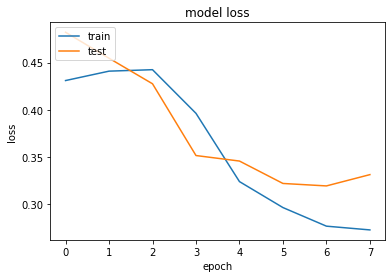

In [59]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

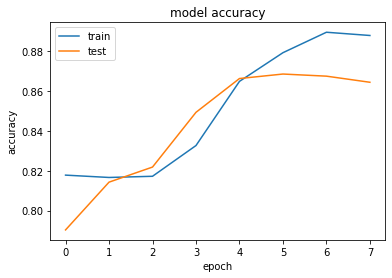

In [60]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show() 

In [61]:
score = model.evaluate(X_test, y_test, verbose=1)

621/621 [==============================] - 10s 15ms/step - loss: 0.3324 - accuracy: 0.8668


In [62]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.3324277997016907
Test Accuracy: 0.8667975068092346


In [83]:
#instance = movies[1110]
#print("Calificacion de la pelicula: " + str(movies_tv["overall"][1110]))
#print(instance)

i = 75
instance = movies[i]
print("Calificacion de la pelicula: " + str(movies_tv["overall"][i]))
print("Clasificacion de la pelicula: " + str(movies_tv["target"][i]))
print(instance)


Calificacion de la pelicula: 3
Clasificacion de la pelicula: 0
Mr. Winkler failed to capture my attention in this ignoble version of the classic Dickens fable. However, it isn't without a certain charm all its own. And to Henry's credit, and partly to my own blame, I have never been able to seperate Henry Winkler from the Fonz of Happy Days. I can't say that I disliked the movie it just doesn't rate up there with the Christmas classics in my estimation and this is simply my own personal take on the film.If you're looking for a Christmas movie that the whole family can enjoy together on occasion then this DVD will fit right in, but if you're looking to gather movies for your library that are the so called "must have Christmas movies" then pass it up for another title.


In [84]:
## Ejemplo de predicción
test_word = []
#test_word.append("Henry Winkler is very good in this twist on the classic story Not conventional remake but version of the story set in early America Give it try")
test_word.append(instance)
tw = tokenizer.texts_to_sequences(test_word)
tw = pad_sequences(tw,maxlen=200)
tw

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,  462, 1987,    5, 1772,   50,  630,    7,
           8,  132,    4,    1,  137,  192,    9,  274,  232,    3,  730,
        1660,   27,   86,  145,    2,    5, 1302,    2,    5,   50,  145,
        3032,   10,   26,  108,   87,  465,    5, 1085,   33,    1,    4,
         494,  485,   10,  217,  140,   11,   10,    1,   12,    9,   46,
         183,  951,   56,   52,   15,    1,  546, 1224,    7,   50,    2,
           8,    6,  372,   50,  145, 

In [85]:
prediction = model.predict(tw)
prediction

array([[0.6313418]], dtype=float32)

In [86]:
if prediction <0.5:
  print("Sentimiento Negativo") 
else:
  print("Sentimiento Positivo")

Sentimiento Positivo
